## Section 0: Import Libraries

In [23]:
# Core libraries
import pandas as pd
import numpy as np
import psycopg2
from dotenv import load_dotenv
import os

# Sklearn - Model Selection
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Sklearn - Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Sklearn - Metrics
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, 
    recall_score, f1_score, roc_auc_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

# Sklearn - Preprocessing
from sklearn.preprocessing import StandardScaler

# Imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbPipeline

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other utilities
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


## Section 1: Data Loading

Load data from PostgreSQL or CSV file.

In [2]:
def fetch_data_from_postgres(config):
    """
    Connects to PostgreSQL and retrieves data from Fact_CustomerChurn.
    
    Parameters:
    -----------
    config : dict
        Database configuration with keys: host, database, user, password, table
    
    Returns:
    --------
    pd.DataFrame : Customer churn data
    """
    conn = None
    try:
        conn = psycopg2.connect(
            host=config['host'],
            database=config['database'],
            user=config['user'],
            password=config['password'],
            port=55432
        )
        print(f"✓ Connected to database '{config['database']}'")
        
        # SQL query to fetch all features
        sql_query = f"""
        SELECT
            "recency", "frequency", "monetary", "avg_order_value",
            "distinct_product_count", "is_churned"
        FROM {config['table']}
        WHERE "recency" IS NOT NULL 
          AND "frequency" IS NOT NULL
          AND "is_churned" IS NOT NULL;
        """
        
        df = pd.read_sql(sql_query, conn)
        print(f"✓ Loaded {len(df)} records from {config['table']}")
        return df
        
    except psycopg2.Error as e:
        print(f"✗ Database error: {e}")
        return pd.DataFrame()
    finally:
        if conn:
            conn.close()
            print("✓ Database connection closed")

In [73]:
# Option 1: Load from PostgreSQL
# Uncomment and configure if using PostgreSQL

db_config = {
    'host': os.getenv('DB_HOST', 'localhost'),
    'database': os.getenv('DB_NAME', 'companyxdb'),
    'user': os.getenv('DB_USER', 'companyx'),
    'password': os.getenv('DB_PASS', 'P@ssW0rd'),
    'table': 'gold.fact_customer_churn'
}
df = fetch_data_from_postgres(db_config)

# Option 2: Load from CSV (for testing)
# df = pd.read_csv("churn.csv")
# print(f"✓ Loaded {len(df)} records from CSV")

# Display basic information
print("\n" + "="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"\nFirst 5 rows:")
display(df.head())

print(f"\nColumn data types:")
print(df.dtypes)

print(f"\nMissing values:")
print(df.isnull().sum())

✓ Connected to database 'companyxdb'
✓ Loaded 19119 records from gold.fact_customer_churn
✓ Database connection closed

DATA OVERVIEW
Shape: (19119, 6)

First 5 rows:


,recency,frequency,monetary,avg_order_value,distinct_product_count,is_churned
0,270,1,2507.03,2507.03,5,0
1,49,1,588.96,588.96,4,0
2,339,1,2419.06,2419.06,2,1
3,263,1,2420.34,2420.34,4,0
4,272,1,2419.06,2419.06,2,1



Column data types:
recency                     int64
frequency                   int64
monetary                  float64
avg_order_value           float64
distinct_product_count      int64
is_churned                  int64
dtype: object

Missing values:
recency                      0
frequency                    0
monetary                     0
avg_order_value           1039
distinct_product_count       0
is_churned                   0
dtype: int64


## Section 2: Advanced Data Cleaning

Comprehensive data cleaning with outlier detection and handling.

In [75]:
def advanced_data_cleaning(df):
    """
    Comprehensive data cleaning with outlier detection and handling.
    """
    print("\n" + "="*80)
    print("STEP 1: ADVANCED DATA CLEANING")
    print("="*80)
    
    df_clean = df.copy()
    cleaning_stats = {}
    initial_rows = len(df_clean)
    
    # 1. Convert all feature columns to numeric
    feature_cols = [col for col in df_clean.columns if col != 'is_churned']
    for col in feature_cols:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
    print(f"✓ Converted {len(feature_cols)} feature columns to numeric")
    
    # 2. Handle missing values
    missing_before = df_clean.isnull().sum().sum()
    print(f"\n Missing values before cleaning: {missing_before}")
    
    # Remove rows with missing target variable
    df_clean = df_clean.dropna(subset=['is_churned'])
    
    # Impute missing features with median
    for col in feature_cols:
        if df_clean[col].isnull().any():
            median_val = df_clean[col].median()
            missing_count = df_clean[col].isnull().sum()
            df_clean[col].fillna(median_val, inplace=True)
            print(f"   - Imputed {missing_count} missing values in {col} with median: {median_val:.2f}")
    
    # 4. Handle infinite values
    df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
    df_clean.dropna(inplace=True)
    print("Handled infinite values")
    
    # 5. Outlier detection using IQR method
    print("\nOutlier Detection (IQR Method):")
    outlier_counts = {}
    
    for col in feature_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 3 * IQR
        upper_bound = Q3 + 3 * IQR
        
        outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
        outlier_counts[col] = outliers
        
        if outliers > 0:
            print(f"   - {col}: {outliers} outliers detected (capping to [{lower_bound:.2f}, {upper_bound:.2f}])")
            df_clean[col] = df_clean[col].clip(lower=lower_bound, upper=upper_bound)
    
    # 6. Handle division-by-zero issues
    df_clean['avg_order_value'] = df_clean['avg_order_value'].clip(lower=0)
    
    # 7. Remove duplicates
    duplicates = df_clean.duplicated().sum()
    if duplicates > 0:
        df_clean = df_clean.drop_duplicates()
        print(f"\nRemoved {duplicates} duplicate rows")
    
    # 8. Final validation
    final_rows = len(df_clean)
    rows_removed = initial_rows - final_rows
    
    cleaning_stats = {
        'initial_rows': initial_rows,
        'final_rows': final_rows,
        'rows_removed': rows_removed,
        'removal_rate': (rows_removed / initial_rows) * 100,
        'outliers_detected': sum(outlier_counts.values())
    }
    
    print(f"\n✓ Cleaning complete:")
    print(f"   - Initial rows: {initial_rows}")
    print(f"   - Final rows: {final_rows}")
    print(f"   - Removed: {rows_removed} ({cleaning_stats['removal_rate']:.2f}%)")
    print(f"   - Total outliers capped: {cleaning_stats['outliers_detected']}")
    
    return df_clean, cleaning_stats

In [76]:
# Execute data cleaning
df_clean, cleaning_stats = advanced_data_cleaning(df)

# Display cleaned data
print("\n" + "="*80)
print("CLEANED DATA SUMMARY")
print("="*80)
print(df_clean.describe())


STEP 1: ADVANCED DATA CLEANING
✓ Converted 5 feature columns to numeric

 Missing values before cleaning: 1039
   - Imputed 1039 missing values in avg_order_value with median: 128.95
Handled infinite values

Outlier Detection (IQR Method):
   - recency: 290 outliers detected (capping to [-449.00, 797.00])
   - frequency: 4262 outliers detected (capping to [1.00, 1.00])
   - monetary: 358 outliers detected (capping to [-4943.05, 6684.02])
   - avg_order_value: 232 outliers detected (capping to [-4197.83, 5694.03])
   - distinct_product_count: 391 outliers detected (capping to [-4.00, 10.00])

Removed 2749 duplicate rows

✓ Cleaning complete:
   - Initial rows: 19119
   - Final rows: 16370
   - Removed: 2749 (14.38%)
   - Total outliers capped: 5533

CLEANED DATA SUMMARY
            recency  frequency      monetary  avg_order_value  \
count  16370.000000    16370.0  16370.000000     16370.000000   
mean     172.161087        1.0    959.893524       796.192942   
std      108.678222     

## Section 3: Train-Test Split and Data Preparation

In [77]:
# Prepare features and target

# X = df_clean.drop(['is_churned'], axis=1) # Can use it if include recency as prediction factor but accuracy may be very high
X = df_clean.drop(['is_churned', 'recency'], axis=1) # Remove recency as use it for labeling churn customer 
y = df_clean['is_churned'].astype(int)

feature_names = X.columns.tolist()

print("="*80)
print("DATA PREPARATION")
print("="*80)
print(f"Total samples: {len(X)}")
print(f"Total features: {len(feature_names)}")
print(f"\nClass distribution:")
print(f"  Non-Churn (0): {(y == 0).sum()} ({(y == 0).sum() / len(y) * 100:.2f}%)")
print(f"  Churn (1): {(y == 1).sum()} ({(y == 1).sum() / len(y) * 100:.2f}%)")

# Train-test split (stratified to maintain class distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n✓ Train-test split complete:")
print(f"   - Train set: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   - Test set: {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"\n   Train class distribution: Non-Churn={np.sum(y_train==0)}, Churn={np.sum(y_train==1)}")
print(f"   Test class distribution:  Non-Churn={np.sum(y_test==0)}, Churn={np.sum(y_test==1)}")

DATA PREPARATION
Total samples: 16370
Total features: 4

Class distribution:
  Non-Churn (0): 10088 (61.62%)
  Churn (1): 6282 (38.38%)

✓ Train-test split complete:
   - Train set: 11459 samples (70.0%)
   - Test set: 4911 samples (30.0%)

   Train class distribution: Non-Churn=7062, Churn=4397
   Test class distribution:  Non-Churn=3026, Churn=1885


## Section 4: Handle Class Imbalance

Use SMOTE and hybrid sampling to balance the classes.

In [7]:
def handle_imbalance(X_train, y_train, method='hybrid'):
    """
    Handle imbalanced classes using SMOTE or hybrid approach.
    """
    print("\n" + "="*80)
    print(f"HANDLING CLASS IMBALANCE - Method: {method.upper()}")
    print("="*80)
    print(f"Original distribution: Non-Churn={np.sum(y_train==0)}, Churn={np.sum(y_train==1)}")
    
    if method == 'smote':
        sampler = SMOTE(random_state=42, k_neighbors=3)
    elif method == 'undersample':
        sampler = RandomUnderSampler(random_state=42)
    elif method == 'hybrid':
        # First undersample majority, then oversample minority
        sampler = ImbPipeline([
            ('undersample', RandomUnderSampler(sampling_strategy="auto", random_state=42)),
            ('oversample', SMOTE(random_state=42, k_neighbors=3))
        ])
    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    print(f"Resampled distribution: Non-Churn={np.sum(y_resampled==0)}, Churn={np.sum(y_resampled==1)}")
    print(f"✓ Balanced dataset: {len(X_resampled)} total samples")
    
    return X_resampled, y_resampled

In [78]:
# Handle imbalance
# X_train_balanced, y_train_balanced = handle_imbalance(X_train, y_train, method='hybrid')
X_train_balanced, y_train_balanced = X_train, y_train

## Section 5: Feature Scaling

In [79]:
# Scale features using StandardScaler
print("\n" + "="*80)
print("FEATURE SCALING")
print("="*80)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

print("✓ Features scaled using StandardScaler")
print(f"   - Train shape: {X_train_scaled.shape}")
print(f"   - Test shape: {X_test_scaled.shape}")
print(f"\n   Sample statistics after scaling (first 3 features):")
for i in range(min(3, X_train_scaled.shape[1])):
    print(f"   Feature {i}: mean={X_train_scaled[:, i].mean():.4f}, std={X_train_scaled[:, i].std():.4f}")


FEATURE SCALING
✓ Features scaled using StandardScaler
   - Train shape: (11459, 4)
   - Test shape: (4911, 4)

   Sample statistics after scaling (first 3 features):
   Feature 0: mean=0.0000, std=0.0000
   Feature 1: mean=0.0000, std=1.0000
   Feature 2: mean=0.0000, std=1.0000


## Section 6: Train Multiple Models

Train Random Forest, Gradient Boosting, and Logistic Regression.

In [80]:
# Define models with optimized hyperparameters
print("\n" + "="*80)
print("MODEL TRAINING")
print("="*80)

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=1000,
        max_depth=15,
        min_samples_split=20,
        min_samples_leaf=10,
        max_features='sqrt',
        random_state=42,
        class_weight='balanced',
        n_jobs=-1
    ),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=200,
        max_depth=10,
        learning_rate=0.05,
        min_samples_split=20,
        min_samples_leaf=10,
        subsample=0.8,
        random_state=42
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        random_state=42,
        solver='lbfgs'
    )
}

print(f"✓ Initialized {len(models)} models")
for name in models.keys():
    print(f"   - {name}")


MODEL TRAINING
✓ Initialized 3 models
   - Random Forest
   - Gradient Boosting
   - Logistic Regression


In [81]:
# Train models and perform cross-validation
results = {}

for name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {name}")
    print(f"{'='*80}")
    
    # Cross-validation
    print("Performing 5-fold cross-validation...")
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X_train_scaled, y_train_balanced, 
                                cv=cv, scoring='roc_auc', n_jobs=-1)
    
    print(f"   CV AUC Scores: {cv_scores}")
    print(f"   CV AUC Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    # Train model
    print("Training model on full training set...")
    model.fit(X_train_scaled, y_train_balanced)
    print("✓ Training complete")
    
    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Calculate metrics
    results[name] = {
        'model': model,
        'cv_auc_mean': cv_scores.mean(),
        'cv_auc_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_pred_proba),
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }
    
    print(f"\nTest Set Performance:")
    print(f"   - Accuracy:  {results[name]['test_accuracy']:.4f}")
    print(f"   - Precision: {results[name]['test_precision']:.4f}")
    print(f"   - Recall:    {results[name]['test_recall']:.4f}")
    print(f"   - F1 Score:  {results[name]['test_f1']:.4f}")
    print(f"   - AUC:       {results[name]['test_auc']:.4f}")

print(f"\n{'='*80}")
print("✓ ALL MODELS TRAINED SUCCESSFULLY")
print(f"{'='*80}")


Training: Random Forest
Performing 5-fold cross-validation...
   CV AUC Scores: [0.82654    0.83187564 0.83082547 0.83066532 0.83642362]
   CV AUC Mean: 0.8313 (+/- 0.0032)
Training model on full training set...
✓ Training complete

Test Set Performance:
   - Accuracy:  0.7797
   - Precision: 0.6627
   - Recall:    0.8674
   - F1 Score:  0.7514
   - AUC:       0.8222

Training: Gradient Boosting
Performing 5-fold cross-validation...
   CV AUC Scores: [0.82095679 0.82988252 0.82309868 0.82628485 0.82938094]
   CV AUC Mean: 0.8259 (+/- 0.0035)
Training model on full training set...
✓ Training complete

Test Set Performance:
   - Accuracy:  0.7770
   - Precision: 0.6685
   - Recall:    0.8313
   - F1 Score:  0.7411
   - AUC:       0.8209

Training: Logistic Regression
Performing 5-fold cross-validation...
   CV AUC Scores: [0.82013233 0.81144573 0.82324435 0.81824419 0.8296992 ]
   CV AUC Mean: 0.8206 (+/- 0.0060)
Training model on full training set...
✓ Training complete

Test Set Perfo

## Section 7: Model Comparison and Selection

In [82]:
# Create comparison dataframe
print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'CV AUC': [f"{r['cv_auc_mean']:.4f} ± {r['cv_auc_std']:.4f}" for r in results.values()],
    'Test Accuracy': [f"{r['test_accuracy']:.4f}" for r in results.values()],
    'Test Precision': [f"{r['test_precision']:.4f}" for r in results.values()],
    'Test Recall': [f"{r['test_recall']:.4f}" for r in results.values()],
    'Test F1': [f"{r['test_f1']:.4f}" for r in results.values()],
    'Test AUC': [f"{r['test_auc']:.4f}" for r in results.values()]
})

display(comparison_df)

# Select best model based on AUC
best_model_name = max(results.keys(), key=lambda x: results[x]['test_auc'])
best_model_results = results[best_model_name]

print(f"\nBEST MODEL: {best_model_name}")
print(f"Test AUC Score: {best_model_results['test_auc']:.4f}")


MODEL PERFORMANCE COMPARISON


,Model,CV AUC,Test Accuracy,Test Precision,Test Recall,Test F1,Test AUC
0,Random Forest,0.8313 ± 0.0032,0.7797,0.6627,0.8674,0.7514,0.8222
1,Gradient Boosting,0.8259 ± 0.0035,0.7770,0.6685,0.8313,0.7411,0.8209
2,Logistic Regression,0.8206 ± 0.0060,0.7654,0.6712,0.7623,0.7139,0.8149



BEST MODEL: Random Forest
Test AUC Score: 0.8222


## Section 8: Detailed Evaluation - Best Model

In [83]:
# Detailed classification report
print("\n" + "="*80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("="*80)

print(classification_report(
    y_test, 
    best_model_results['predictions'],
    target_names=['Non-Churn (0)', 'Churn (1)'],
    digits=4
))

# Confusion Matrix
print("\nCONFUSION MATRIX:")
cm = confusion_matrix(y_test, best_model_results['predictions'])
print(f"\n                 Predicted")
print(f"                 Non-Churn  Churn")
print(f"Actual Non-Churn    {cm[0][0]:5d}    {cm[0][1]:5d}")
print(f"       Churn        {cm[1][0]:5d}    {cm[1][1]:5d}")

# Calculate additional metrics
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp)
npv = tn / (tn + fn) if (tn + fn) > 0 else 0
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"\nADDITIONAL METRICS:")
print(f"   - Specificity (TNR):          {specificity:.4f}")
print(f"   - Negative Predictive Value:  {npv:.4f}")
print(f"   - False Positive Rate:        {fpr:.4f}")
print(f"   - False Negative Rate:        {fnr:.4f}")


DETAILED CLASSIFICATION REPORT - Random Forest
               precision    recall  f1-score   support

Non-Churn (0)     0.8977    0.7250    0.8022      3026
    Churn (1)     0.6627    0.8674    0.7514      1885

     accuracy                         0.7797      4911
    macro avg     0.7802    0.7962    0.7768      4911
 weighted avg     0.8075    0.7797    0.7827      4911


CONFUSION MATRIX:

                 Predicted
                 Non-Churn  Churn
Actual Non-Churn     2194      832
       Churn          250     1635

ADDITIONAL METRICS:
   - Specificity (TNR):          0.7250
   - Negative Predictive Value:  0.8977
   - False Positive Rate:        0.2750
   - False Negative Rate:        0.1326


## Section 9: Feature Importance Analysis


FEATURE IMPORTANCE - Random Forest

TOP 10 MOST IMPORTANT FEATURES:
    1. distinct_product_count              0.6054 ████████████████████████████████████████████████████████████
    2. monetary                            0.2759 ███████████████████████████
    3. avg_order_value                     0.1187 ███████████
    4. frequency                           0.0000 


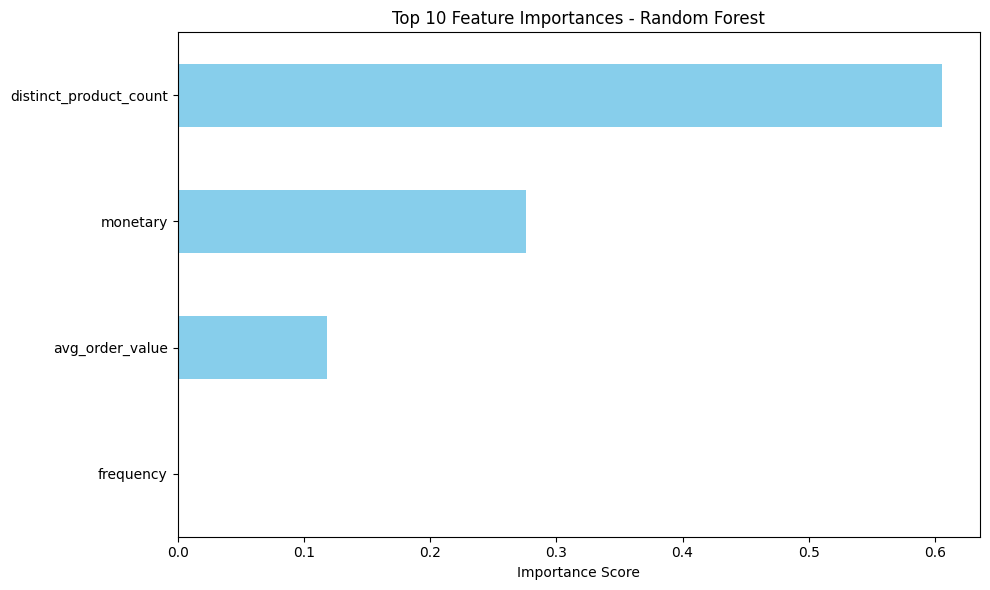

In [84]:
# Feature importance (for tree-based models)
if hasattr(best_model_results['model'], 'feature_importances_'):
    print("\n" + "="*80)
    print(f"FEATURE IMPORTANCE - {best_model_name}")
    print("="*80)
    
    importances = pd.Series(
        best_model_results['model'].feature_importances_,
        index=feature_names
    ).sort_values(ascending=False)
    
    print("\nTOP 10 MOST IMPORTANT FEATURES:")
    for i, (feat, imp) in enumerate(importances.head(10).items(), 1):
        print(f"   {i:2d}. {feat:35s} {imp:.4f} {'█' * int(imp * 100)}")
    
    # Visualize top 10 features
    plt.figure(figsize=(10, 6))
    importances.head(10).plot(kind='barh', color='skyblue')
    plt.xlabel('Importance Score')
    plt.title(f'Top 10 Feature Importances - {best_model_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(f"\n{best_model_name} does not support feature importance analysis.")

## Section 10: Overfitting Analysis

In [85]:
print("\n" + "="*80)
print("OVERFITTING ANALYSIS")
print("="*80)

for name, result in results.items():
    model = result['model']
    
    # Train set performance
    y_train_pred = model.predict(X_train_scaled)
    y_train_proba = model.predict_proba(X_train_scaled)[:, 1]
    
    train_auc = roc_auc_score(y_train_balanced, y_train_proba)
    train_acc = accuracy_score(y_train_balanced, y_train_pred)
    train_f1 = f1_score(y_train_balanced, y_train_pred)
    
    # Test set performance
    test_auc = result['test_auc']
    test_acc = result['test_accuracy']
    test_f1 = result['test_f1']
    
    # Calculate gaps
    auc_gap = train_auc - test_auc
    acc_gap = train_acc - test_acc
    f1_gap = train_f1 - test_f1
    
    print(f"\n{name}:")
    print(f"   Train AUC: {train_auc:.4f} | Test AUC: {test_auc:.4f} | Gap: {auc_gap:.4f}")
    print(f"   Train ACC: {train_acc:.4f} | Test ACC: {test_acc:.4f} | Gap: {acc_gap:.4f}")
    print(f"   Train F1:  {train_f1:.4f} | Test F1:  {test_f1:.4f} | Gap: {f1_gap:.4f}")
    
    # Overfitting assessment
    if auc_gap > 0.1:
        print(f"   Significant overfitting detected (AUC gap: {auc_gap:.4f})")
    elif auc_gap > 0.05:
        print(f"   Mild overfitting (AUC gap: {auc_gap:.4f})")
    else:
        print(f"   Good generalization (AUC gap: {auc_gap:.4f})")


OVERFITTING ANALYSIS

Random Forest:
   Train AUC: 0.8644 | Test AUC: 0.8222 | Gap: 0.0422
   Train ACC: 0.7898 | Test ACC: 0.7797 | Gap: 0.0101
   Train F1:  0.7612 | Test F1:  0.7514 | Gap: 0.0098
   Good generalization (AUC gap: 0.0422)

Gradient Boosting:
   Train AUC: 0.8733 | Test AUC: 0.8209 | Gap: 0.0524
   Train ACC: 0.7984 | Test ACC: 0.7770 | Gap: 0.0214
   Train F1:  0.7644 | Test F1:  0.7411 | Gap: 0.0234
   Mild overfitting (AUC gap: 0.0524)

Logistic Regression:
   Train AUC: 0.8206 | Test AUC: 0.8149 | Gap: 0.0057
   Train ACC: 0.7694 | Test ACC: 0.7654 | Gap: 0.0039
   Train F1:  0.7190 | Test F1:  0.7139 | Gap: 0.0052
   Good generalization (AUC gap: 0.0057)


## Section 11: ROC Curve Visualization

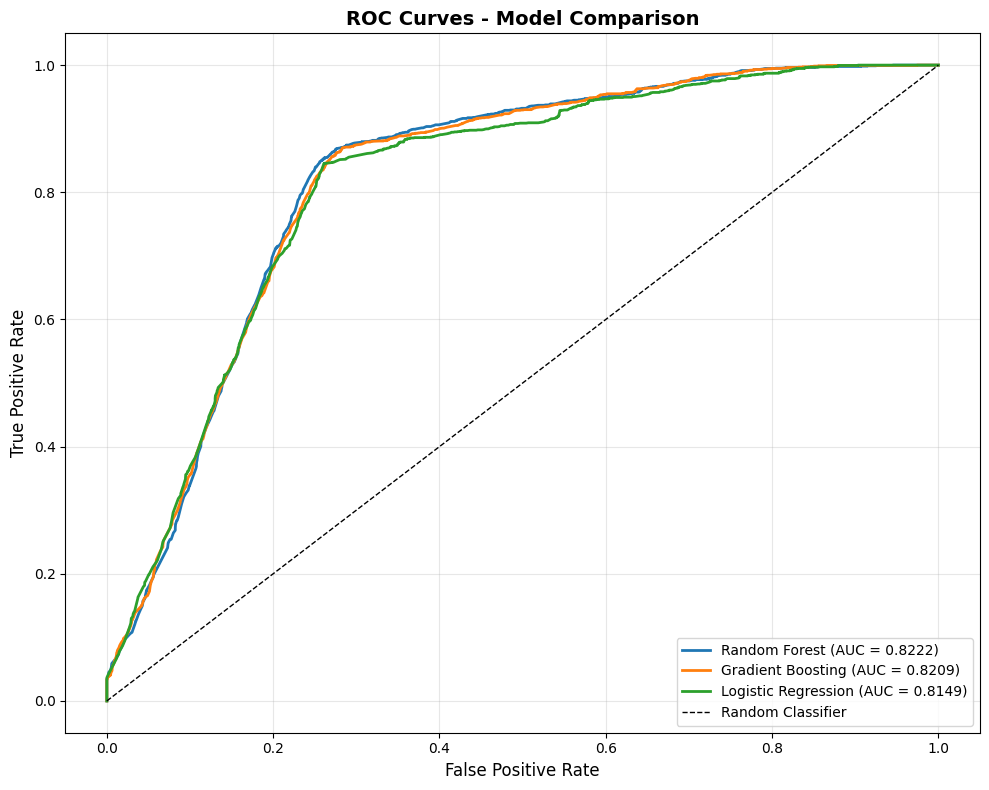

In [86]:
# Plot ROC curves for all models
plt.figure(figsize=(10, 8))

for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['probabilities'])
    auc_score = result['test_auc']
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

# Plot diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Model Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Section 12: Predict on New Customers

In [87]:
def predict_new_customers(model, scaler, feature_names, new_data_df):
    """Make predictions on new customer data."""
    print("\n" + "="*80)
    print("PREDICTING NEW CUSTOMERS")
    print("="*80)
    
    # Select features in same order
    X_new = new_data_df[feature_names]
    
    # Scale features
    X_new_scaled = scaler.transform(X_new)
    
    # Make predictions
    predictions = model.predict(X_new_scaled)
    probabilities = model.predict_proba(X_new_scaled)
    
    # Create results
    results_df = pd.DataFrame({
        'Customer_ID': range(1, len(predictions) + 1),
        'Prediction': ['CHURN' if p == 1 else 'NON-CHURN' for p in predictions],
        'Churn_Probability': probabilities[:, 1],
        'Non_Churn_Probability': probabilities[:, 0],
        'Risk_Level': ['HIGH' if p > 0.7 else 'MEDIUM' if p > 0.4 else 'LOW' 
                       for p in probabilities[:, 1]]
    })
    
    print("\nPREDICTION RESULTS:")
    display(results_df)
    
    return results_df

In [88]:
# Sample new customer data
new_customers = pd.DataFrame([
    {
        "recency": 10, "frequency": 25, "monetary": 4500.0, 
        "avg_order_value": 180.0, "distinct_product_count": 50
    },
    {
        "recency": 400, "frequency": 3, "monetary": 500.0,
        "avg_order_value": 166.6, "distinct_product_count": 5
    },
    {
        "recency": 90, "frequency": 12, "monetary": 2000.0,
        "avg_order_value": 166.67, "distinct_product_count": 20
    }
])

print("\nNew Customer Data:")
display(new_customers)

# Make predictions
predictions_df = predict_new_customers(
    best_model_results['model'], 
    scaler, 
    feature_names, 
    new_customers
)


New Customer Data:


,recency,frequency,monetary,avg_order_value,distinct_product_count
0,10,25,4500.0,180.00,50
1,400,3,500.0,166.60,5
2,90,12,2000.0,166.67,20



PREDICTING NEW CUSTOMERS

PREDICTION RESULTS:


,Customer_ID,Prediction,Churn_Probability,Non_Churn_Probability,Risk_Level
0,1,NON-CHURN,0.011424,0.988576,LOW
1,2,NON-CHURN,0.135741,0.864259,LOW
2,3,NON-CHURN,0.035837,0.964163,LOW


## Section 13: Summary and Recommendations

In [89]:
print("\n" + "="*80)
print("PROJECT SUMMARY")
print("="*80)

print(f"✓ Data Cleaning:")
print(f"   - Initial records: {cleaning_stats['initial_rows']}")
print(f"   - Final records: {cleaning_stats['final_rows']}")
print(f"   - Removal rate: {cleaning_stats['removal_rate']:.2f}%")

print(f"✓ Models Trained: {len(models)}")
for name in models.keys():
    print(f"   - {name}")

print(f"Best Model: {best_model_name}")
print(f"   - Test AUC: {best_model_results['test_auc']:.4f}")
print(f"   - Test F1: {best_model_results['test_f1']:.4f}")
print(f"   - Test Accuracy: {best_model_results['test_accuracy']:.4f}")

print("\nRECOMMENDATIONS:")
print("   1. Focus retention efforts on customers with Churn Probability > 0.7")
print("   2. Monitor top 3 feature importances closely for early intervention")
print("   3. Re-train model monthly with new data to maintain performance")
print("   4. Consider A/B testing retention strategies on MEDIUM risk customers")
print("   5. Integrate predictions into CRM for automated alerts")

print("="*80)
print("ANALYSIS COMPLETE")
print("="*80)


PROJECT SUMMARY
✓ Data Cleaning:
   - Initial records: 19119
   - Final records: 16370
   - Removal rate: 14.38%
✓ Models Trained: 3
   - Random Forest
   - Gradient Boosting
   - Logistic Regression
Best Model: Random Forest
   - Test AUC: 0.8222
   - Test F1: 0.7514
   - Test Accuracy: 0.7797

RECOMMENDATIONS:
   1. Focus retention efforts on customers with Churn Probability > 0.7
   2. Monitor top 3 feature importances closely for early intervention
   3. Re-train model monthly with new data to maintain performance
   4. Consider A/B testing retention strategies on MEDIUM risk customers
   5. Integrate predictions into CRM for automated alerts
ANALYSIS COMPLETE
